In [4]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from final_algo import attr_threshold
from paper_sims_util import confusion, MCC_from_4
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
N = 100 #try for 25, 50, 200
p = 100
d = 0.01
if d is None:
    run_name = 'ROC_N_{}_p_{}'.format(N, p)
    d = 0.01
else:
    run_name = 'new_ROC/ROC_N_{}_p_{}_d_{}'.format(N, p, d)
NUM_GRAPHS = 30

In [ ]:
l = pickle.load(open)

In [128]:
try:
    df = pd.read_pickle('{}_new_graph.pkl'.format(run_name))
    print('Loaded df', df.RunID.nunique())
except:
    all_results = []
    data = []
    for graph_num in range(NUM_GRAPHS):
        print(graph_num)
    #     if graph_num in prev_df.RunID.values():
    #         continue #do not load
        try:
            res = pickle.load(open('{}_{}_result.pkl'.format(run_name, graph_num), 'rb'))
        except:
            continue
        result, FPTP_dict, omega, _, _ = res
        for algo_name in FPTP_dict.keys():
            for lamb in FPTP_dict[algo_name].keys():
                omega_hat = result[algo_name][lamb]
                TP, TN, FP, FN = confusion(omega_hat, omega)
                TPR = TP/(TP + FN)
                FPR = FP/(FP + TN)
                mcc = MCC_from_4(TP, TN, FP, FN)
                data.append((graph_num, algo_name, lamb, FPR, TPR, mcc, (TP, TN, FP, FN)))
# df.to_pickle('{}_df.pkl'.format(run_name))
# print(len(all_results), 'unique runs')
        df = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'Lambda', 'FPR', 'TPR', 'MCC', 'TP_TN_FP_FN'])
        df['groupby_lambda'] = [x[1] if type(x) == tuple else x for x in df.Lambda.values]
        df.to_pickle('{}_new_graph.pkl'.format(run_name))
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [146]:
df['TP'] = [x[0] for x in df['TP_TN_FP_FN']]
df['TN'] = [x[1] for x in df['TP_TN_FP_FN']]
df['FP'] = [x[3] for x in df['TP_TN_FP_FN']]
df['FN'] = [x[2] for x in df['TP_TN_FP_FN']]

In [147]:
df.TPR = df.TP/(df.TP + df.FN)
df.FPR = df.FP/(df.FP + df.TN)

In [149]:
df.head()

,RunID,AlgoName,Lambda,FPR,TPR,MCC,TP_TN_FP_FN,groupby_lambda,TP,TN,FP,FN
0,0,our,0.75,0.004257,0.882353,0.604579,"(15, 4912, 2, 21)",0.750000,15,4912,21,2
1,0,our,0.772222,0.003045,0.875000,0.712817,"(21, 4911, 3, 15)",0.772222,21,4911,15,3
2,0,our,0.794444,0.003857,0.708333,0.575904,"(17, 4907, 7, 19)",0.794444,17,4907,19,7
3,0,our,0.816667,0.003053,0.567568,0.572243,"(21, 4898, 16, 15)",0.816667,21,4898,15,16
4,0,our,0.838889,0.003059,0.446809,0.506464,"(21, 4888, 26, 15)",0.838889,21,4888,15,26


In [150]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'groupby_lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()
    FPR_std = item.FPR.std()
    TPR_std = item.TPR.std()
    algo_name = key[0]
    run_id = item.RunID
    agg_data.append((run_id, algo_name, key[1], FPR_rate, TPR_rate, FPR_std, TPR_std))

In [151]:
agg_df = pd.DataFrame(agg_data, columns=['RunID','Algorithm', 'Lambda', 'False Positive Rate', 'True Positive Rate', 'FPR_std', 'TPR_std'])



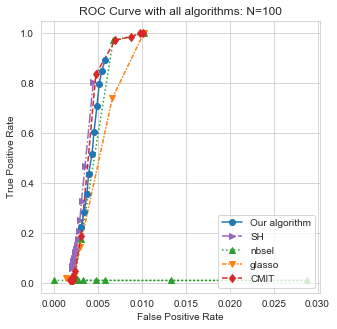

new_ROC/ROC_N_100_p_100_d_0.01


In [153]:
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))
#plt.xlim((0,1000))

all_algos = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_algos = ['our', 'SH']

smol = False
if smol:
    algos = relevant_algos
    ERRS = True
    small_name = 'errs'
else:
    algos = all_algos
    ERRS = False
    small_name = 'all'
    
for z, algo_name in enumerate(algos):
    plot_df = agg_df[agg_df.Algorithm == algo_name]
    plot_df.sort_values('False Positive Rate')
    x = plot_df['False Positive Rate']
    y = plot_df['True Positive Rate']
    std = plot_df['TPR_std']
    plt.plot(x, y,
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name],
             zorder = (10 if algo_name == 'our' else 1),
             alpha = (1. if algo_name != 'our' else 1.))
    if ERRS:
        plt.fill_between(x, y-std, y+std, alpha=0.2, color = colors[algo_name])
sns.set_style("whitegrid")
plt.legend(loc='lower right')
if smol:
    title = 'ROC Curve with standard error: N={}'.format(N)
else:
    title = 'ROC Curve with all algorithms: N={}'.format(N)
plt.title(title)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
fig.savefig('final_images/ROC_curve_{}_{}.png'.format(N, small_name))
print(run_name)

In [140]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'groupby_lambda']):
    if item.AlgoName.values[0] == 'glasso':
        item = item[(item.Lambda <= 1.0) & (item.Lambda >= 0.01)]
    mcc = item.MCC.mean()
    lamb = key[1]
    lambda_max = df[df.AlgoName == key[0]]['groupby_lambda'].max()
    lambda_min = df[df.AlgoName == key[0]]['groupby_lambda'].min()
    print(lambda_max, lambda_min, lamb)
    x_axis = (lamb - lambda_min)/(lambda_max-lambda_min)
    mcc_std = item.MCC.std()
    algo_name = key[0]
    run_id = item.RunID
    agg_data.append((key[0], lamb, x_axis, mcc, mcc_std))

1.0 0.05 0.05
1.0 0.05 0.1
1.0 0.05 0.15
1.0 0.05 0.2
1.0 0.05 0.25
1.0 0.05 0.3
1.0 0.05 0.35
1.0 0.05 0.39999999999999997
1.0 0.05 0.44999999999999996
1.0 0.05 0.49999999999999994
1.0 0.05 0.5499999999999999
1.0 0.05 0.6
1.0 0.05 0.65
1.0 0.05 0.7
1.0 0.05 0.75
1.0 0.05 0.7999999999999999
1.0 0.05 0.85
1.0 0.05 0.9
1.0 0.05 0.95
1.0 0.05 1.0
15.848931924611133 0.0001 0.0001
15.848931924611133 0.0001 0.00018779508018514912
15.848931924611133 0.0001 0.00035266992141746593
15.848931924611133 0.0001 0.0006622967617148325
15.848931924611133 0.0001 0.0012437607347260157
15.848931924611133 0.0001 0.002335721469090121
15.848931924611133 0.0001 0.004386370005779541
15.848931924611133 0.0001 0.00823738706957102
15.848931924611133 0.0001 0.015469407652462002
15.848931924611133 0.0001 0.029050786505108613
15.848931924611133 0.0001 0.0545559478116852
15.848931924611133 0.0001 0.10245338593872233
15.848931924611133 0.0001 0.1924024182760241
15.848931924611133 0.0001 0.3613222756796255
15.848931924

In [141]:
agg_df = pd.DataFrame(agg_data, columns = ['Algorithm', 'lamb', 'x_axis', 'mcc', 'mcc_std'])

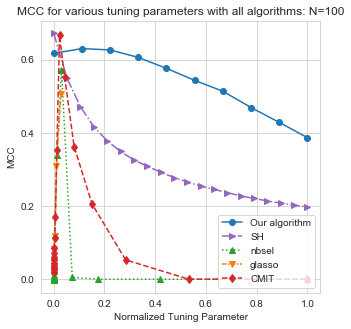

In [142]:
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))

#plt.xlim((0,1000))
all_algos = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_algos = ['our', 'SH']

smol = False
if smol:
    algos = relevant_algos
    ERRS = True
    small_name = 'errs'
else:
    algos = all_algos
    ERRS = False
    small_name = 'all'

for algo_name in algos:
    plot_df = agg_df[agg_df.Algorithm == algo_name]
    plot_df.sort_values('x_axis')
    x = plot_df['x_axis']
    y = plot_df['mcc']
    std = plot_df['mcc_std']
    plt.plot(x, y,
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name])
    if ERRS:
        plt.fill_between(x, y-std, y+std, alpha=0.2, color = colors[algo_name])
sns.set_style("whitegrid")
if smol:
    legend_loc = 'upper right'
else:
    legend_loc = 'lower right'
plt.legend(loc=legend_loc)
if smol:
    title = 'MCC for various tuning parameters with standard error: N={}'.format(N)
else:
    title = 'MCC for various tuning parameters with all algorithms: N={}'.format(N)
plt.title(title)
plt.xlabel("Normalized Tuning Parameter")
plt.ylabel("MCC")

plt.show()
fig.savefig('final_images/MCC_curves_{}_{}.png'.format(N, small_name))